In [53]:
# import libraries
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
# load data set
df = pd.read_csv('...\onlineRetail.csv', encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
# descriptive stats
df['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [5]:
# Split the dataframe into 3 months and 6 months
df_3m = df[(df.InvoiceDate < date(2011,6,1)) & (df.InvoiceDate >= date(2011,3,1))].reset_index(drop=True)
df_6m = df[(df.InvoiceDate >= date(2011,6,1)) & (df.InvoiceDate < date(2011,12,1))].reset_index(drop=True)

C:\Users\hkaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  
C:\Users\hkaur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Do RFM analysis on the 3 months data
# create a new dataframe containing unique customer ids
df_customer = pd.DataFrame(df_3m['CustomerID'].unique())
df_customer.columns = ['CustomerID']

In [7]:
# Calculate Recency
df_latest_purchase = df_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
df_latest_purchase.columns = ['CustomerID','LatestPurchaseDate']
df_latest_purchase['Recency'] = (df_latest_purchase['LatestPurchaseDate'].max() - df_latest_purchase['LatestPurchaseDate']).dt.days

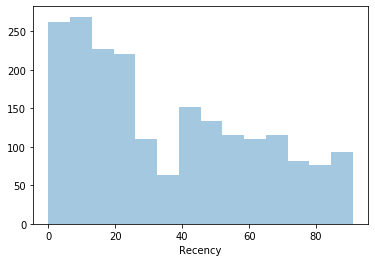

In [8]:
sns.distplot(df_latest_purchase['Recency'], kde = False)

In [9]:
df_customer = pd.merge(df_customer, df_latest_purchase[['CustomerID','Recency']], on='CustomerID')

In [10]:
df_customer.head()

,CustomerID,Recency
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


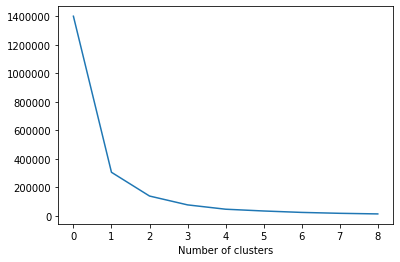

In [11]:
# kmeans on Recency
# Elbow method to dtermine clusters
recency = df_customer[['Recency']]
squared_error = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, max_iter=1000).fit(recency)
    df_latest_purchase["clusters"] = kmeans.labels_
    squared_error.append(kmeans.inertia_)
    
plt.figure()
plt.plot(squared_error)
plt.xlabel("Number of clusters")
plt.show()

In [12]:
# train kmeans using 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Recency']])
df_customer['RecencyCluster'] = kmeans.predict(df_customer[['Recency']])

In [13]:
def reorder_clusters(cluster_label, target_column,df,ascending):
    df_new = df.groupby(cluster_label)[target_column].mean().reset_index()
    df_new = df_new.sort_values(by=target_column,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_label,'index']], on=cluster_label)
    df_final = df_final.drop([cluster_label],axis=1)
    df_final = df_final.rename(columns={"index":cluster_label})
    return df_final

In [14]:
df_customer = reorder_clusters('RecencyCluster', 'Recency',df_customer,False)
df_customer.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,386.0,76.919689,8.347721,64.0,69.0,76.0,84.0,91.0
1,489.0,50.047035,7.321359,39.0,43.0,49.0,56.0,63.0
2,482.0,24.367220,4.979376,17.0,20.0,23.0,27.0,35.0
3,670.0,8.249254,4.428366,0.0,5.0,8.0,12.0,16.0


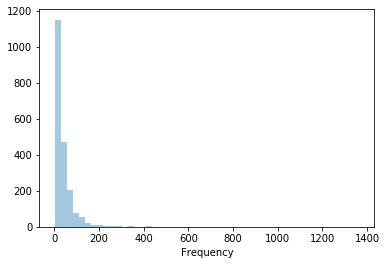

In [15]:
# Frequency
df_frequency = df_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']
sns.distplot(df_frequency['Frequency'], kde = False)

In [16]:
df_customer = pd.merge(df_customer, df_frequency[['CustomerID','Frequency']], on='CustomerID')
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,14620.0,12,3,30
1,14740.0,4,3,89
2,17068.0,11,3,76
3,12971.0,4,3,73
4,15194.0,6,3,64


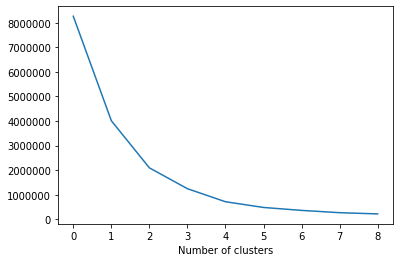

In [17]:
# kmeans on Frequency
# Elbow method to dtermine clusters
frequency = df_customer[['Frequency']]
squared_error = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, max_iter=1000).fit(frequency)
    df_frequency["clusters"] = kmeans.labels_
    squared_error.append(kmeans.inertia_)
    
plt.figure()
plt.plot(squared_error)
plt.xlabel("Number of clusters")
plt.show()

In [18]:
# train kmeans using 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Frequency']])
df_customer['FrequencyCluster'] = kmeans.predict(df_customer[['Frequency']])

In [19]:
df_customer = reorder_clusters('FrequencyCluster', 'Frequency',df_customer,True)
df_customer.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1761.0,24.254401,17.522583,1.0,10.00,20.0,35.0,69.0
1,252.0,114.984127,43.907724,70.0,81.00,103.0,130.0,285.0
2,12.0,482.166667,129.263532,330.0,395.25,444.0,564.0,730.0
3,2.0,1227.000000,193.747258,1090.0,1158.50,1227.0,1295.5,1364.0


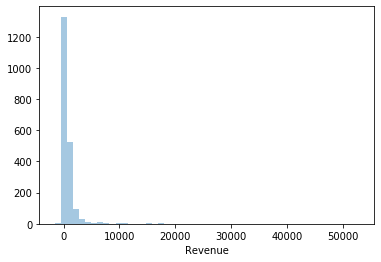

In [20]:
# Monetory value
df_3m['Revenue'] = df_3m['UnitPrice'] * df_3m['Quantity']
df_revenue = df_3m.groupby('CustomerID')['Revenue'].sum().reset_index()
df_revenue.columns = ['CustomerID','Revenue']
sns.distplot(df_revenue['Revenue'], kde = False)

In [21]:
df_customer = pd.merge(df_customer, df_revenue[['CustomerID','Revenue']], on='CustomerID')
df_customer.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,14620.0,12,3,30,0,393.28
1,15194.0,6,3,64,0,1439.02
2,18044.0,5,3,57,0,808.96
3,18075.0,12,3,35,0,638.12
4,15241.0,0,3,64,0,947.55


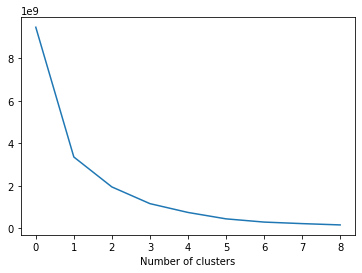

In [22]:
# kmeans on Frequency
# Elbow method to dtermine clusters
revenue = df_customer[['Revenue']]
squared_error = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, max_iter=1000).fit(revenue)
    df_revenue["clusters"] = kmeans.labels_
    squared_error.append(kmeans.inertia_)
    
plt.figure()
plt.plot(squared_error)
plt.xlabel("Number of clusters")
plt.show()

In [23]:
# train kmeans using 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_customer[['Revenue']])
df_customer['RevenueCluster'] = kmeans.predict(df_customer[['Revenue']])
df_customer = reorder_clusters('RevenueCluster', 'Revenue',df_customer,True)
df_customer.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1895.0,495.683251,417.922397,-1591.20,207.3250,358.380,667.9450,1890.94
1,115.0,3320.063487,1500.928750,1919.04,2223.7600,2825.470,3825.5800,7969.99
2,14.0,15430.685714,4595.246762,9864.26,11268.3675,15417.215,17602.3625,26113.81
3,3.0,39035.626667,12320.840433,29174.30,32129.8900,35085.480,43966.2900,52847.10


In [24]:
# Overall Segmentation
df_customer['OverallScore'] = df_customer['RecencyCluster'] + df_customer['FrequencyCluster'] + df_customer['RevenueCluster']
df_customer.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()
df_customer['Segment'] = 'Low-Value'
df_customer.loc[df_customer['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_customer.loc[df_customer['OverallScore']>4,'Segment'] = 'High-Value'

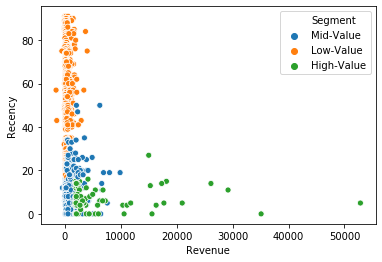

In [25]:
sns.scatterplot(x = 'Revenue', y='Recency', hue='Segment', data=df_customer)

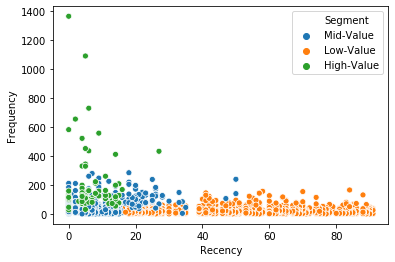

In [26]:
sns.scatterplot(x = 'Recency', y='Frequency', hue='Segment', data=df_customer)

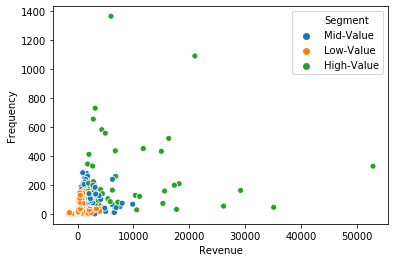

In [27]:
sns.scatterplot(x = 'Revenue', y='Frequency', hue='Segment', data=df_customer)

In [28]:
# Lifetime value prediction on the 6 months dataframe
df_6m.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom


In [58]:
# Since no cost is present, revenue becomes lifetime value for the customer
df_6m['Revenue'] = df_6m['UnitPrice'] * df_6m['Quantity']
df_customer_6m = df_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
df_customer_6m.columns = ['CustomerID','m6_Revenue']
df_customer_6m.head()

,CustomerID,m6_Revenue
0,12347.0,2261.75
1,12348.0,310.00
2,12349.0,1757.55
3,12352.0,944.23
4,12356.0,58.35


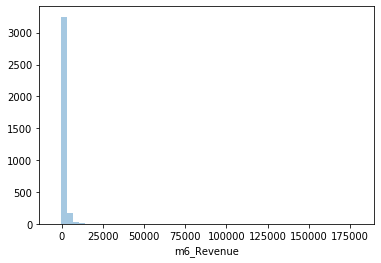

In [59]:
sns.distplot(df_customer_6m['m6_Revenue'], kde = False)

In [60]:
df_combined = pd.merge(df_customer, df_customer_6m, on='CustomerID', how='left')
df_combined.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,NaN
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


In [61]:
df_combined = df_combined.fillna(0)

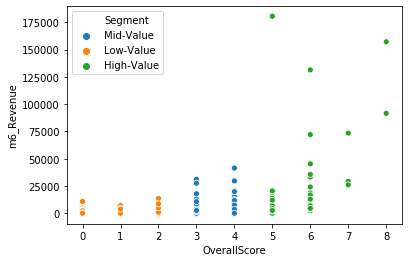

In [62]:
sns.scatterplot(x = 'OverallScore', y='m6_Revenue', hue='Segment', data=df_combined)

In [63]:
# positive correlation between lifetime value and RFM score
# lets apply kmeans to segment customers based on lifetime value
# remove outliers
df_combined = df_combined[df_combined['m6_Revenue']<df_combined['m6_Revenue'].quantile(0.99)]

kmeans = KMeans(n_clusters=3)
kmeans.fit(df_combined[['m6_Revenue']])
df_combined['LTVCluster'] = kmeans.predict(df_combined[['m6_Revenue']])

df_combined = reorder_clusters('LTVCluster', 'm6_Revenue',df_combined,True)

df_combined.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1726.0,574.111866,612.412320,-609.40,0.0000,371.200,953.7700,2202.37
1,254.0,3827.940157,1429.189957,2213.72,2742.2600,3444.715,4458.8725,7946.90
2,26.0,12377.135000,3210.865481,8439.09,9607.3225,11861.385,13745.0575,19289.53


In [64]:
# Train lifetime values using XGBoost model
# first, convert categorical variables into dummy variables
df_dummy = pd.get_dummies(df_combined)
df_dummy.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,991.54,0,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,1322.75,0,0,0,1
3,15241.0,0,3,64,0,947.55,0,3,791.04,0,0,0,1
4,12679.0,13,3,47,0,869.13,0,3,189.54,0,0,0,1


In [65]:
# since there are many variables, we calculate corrrelation matrix to see which variables are important for lifetime value
corr_matrix = df_dummy.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.852888
Revenue               0.595215
RevenueCluster        0.514442
Segment_High-Value    0.408951
Frequency             0.363705
OverallScore          0.361738
FrequencyCluster      0.359484
RecencyCluster        0.206179
Segment_Mid-Value     0.113526
CustomerID           -0.091690
Recency              -0.204516
Segment_Low-Value    -0.254175
Name: LTVCluster, dtype: float64

In [66]:
X = df_dummy.drop(['LTVCluster','m6_Revenue'],axis=1)
y = df_dummy['LTVCluster']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [43]:
conda install -c anaconda py-xgboost 

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\hkaur\Anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          12 KB  anaconda
    ca-certificates-2019.8.28  |                0         165 KB  anaconda
    certifi-2019.9.11          |           py37_0         155 KB  anaconda
    conda-4.8.1                |           py37_0         3.0 MB  anaconda
    libxgboost-0.90            |                1         3.9 MB  anaconda
    openssl-1.1.1d             |       he774522_2         5.7 MB  anaconda
    py-xgboost-0.90            |           py37_1          80 KB  anaconda
    ------------------------------------------------------------
                                           Total:        13.0 MB

The following NEW packages will be INSTALLED:



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda




In [45]:
import xgboost as xgb

In [68]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=1).fit(X_train, y_train)

In [75]:
print('Accuracy of XGB model on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))

Accuracy of XGB model on training set: 0.96


In [76]:
print('Accuracy of XGB model on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test, y_test)))

Accuracy of XGB model on test set: 0.87


In [71]:
y_pred = ltv_xgb_model.predict(X_test)

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        87
           1       0.50      0.46      0.48        13
           2       0.00      0.00      0.00         1

    accuracy                           0.87       101
   macro avg       0.48      0.47      0.47       101
weighted avg       0.88      0.87      0.87       101

